<a href="https://colab.research.google.com/github/KartikChugh/MachineLearning/blob/master/svm_classification_moons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Task: Moons

In this project, we implement kernel SVMs capable of classifying non-linear data and evaluate their performance against standard library solutions using Scikit-Learn's [cluster generation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) utilities.


In [1]:
# Import some common packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

# Setup matplotlib for graphical display
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To make this notebook's output stable across runs
SEED = 42
np.random.seed(SEED)

## 1. Dataset

Sklearn provides several utility functions for loading and generating datasets to work with, including `make_moons`.

> `make_circles` and **`make_moons` generate 2d binary classification datasets that are challenging to certain algorithms** (e.g. centroid-based clustering or linear classification), including optional Gaussian noise. They are useful for visualisation. `make_circles` produces Gaussian data with a spherical decision boundary for binary classification, while **`make_moons` produces two interleaving half circles.**

We start by using the function to generate 500 such data points (jittered with a bit of random noise), and then divide them into train and test sets.

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.15, random_state=SEED)
y = y*2-1.0 # convert the labels from {0,1} to {-1, +1}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

The `plot_svm()` function below visualizes the decision boundary, margin, and support vectors in a 2D feature space for the classifiers we will train. 

It assumes that a provided classifier has a `support_vectors_` attribute, used to render all support vectors in red.

In [3]:
def plot_svm (clf, X, y, axes=[-2, 3, -2, 2]):
    """
    Generate a simple plot of SVM including the decision boundary, margin, and its training data
    
    Parameters
    ----------
    clf: your classifier handle
    X: feature matrix shape(m_samples, n_features)
    y: label vector shape(m_samples, )
    axes: (optional) the axes of the plot in format [xmin, xmax, ymin, ymax] 
    """
    # Create a mesh grid based on the provided axes (100 x 100 resolution)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s,x1s) # create a mesh grid
    X_mesh = np.c_[x0.ravel(), x1.ravel()] # convert all mesh points into 2-D points
    y_pred = clf.predict(X_mesh).reshape(x0.shape) # predict then covert back to the 2-D
    y_decision = clf.decision_function(X_mesh).reshape(x0.shape)

    plt.figsize=(16, 9)
    plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], "bo", label="Class -1")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "go", label="Class +1")
    # Plot out the support vectors (in red)
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], s=80, c="r", label="Support Vectors")
    # Plot decision boundary and margins
    plt.contourf(x0,x1, y_pred, cmap = plt.cm.brg, alpha = 0.1)
    plt.contourf(x0,x1, y_decision, cmap = plt.cm.brg, alpha = 0.2)
    plt.contour(x0, x1, y_decision, colors='k',
                 levels=[-1, 0, 1], alpha=0.5,
                 linestyles=['--', '-', '--'])
    plt.legend(loc="lower right")
    plt.axis("auto")

    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0) 

- - -
## 2. Model Training, Tuning, & Testing

Next, we feed the train data to sklearn's Support Vector Classifier (SVC) module, training three models with different **kernels:** (1) **Linear**, (2) **Polynomial**, and (3) **Gaussian RBF**. 

Our hyperparameter selection process consists of a **grid search**, which iterates across combinations of hyperparameters and selects the best for each kernel (based on **5-fold cross validation**).

We then report their respective confusion matrices, classification metrics, and plot visualizations computed with the test data.


The below code sets up and executes a grid search across wide ranges of values.

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC(random_state=SEED)
hyperparams = [
                {
                  'kernel': ['linear'], 
                  'C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e4]
                },
                {
                  'kernel': ['poly'], 
                  'C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e4],
                  'degree': [2, 3, 4],
                  'coef0': [0, 1, 10, 100]
                },
                {
                  'kernel': ['rbf'], 
                  'C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e4],
                  'gamma': [1e-4, 1e-2, 1e0, 1e2, 1e4],
                }
              ]

In [5]:
grid_search = GridSearchCV(svc, param_grid=hyperparams, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train);

We then define utility functions to retrieve the optimal hyperparameters and report the relevant ones for a given kernel, alongside its results on test data.

In [6]:
# Returns the best model for each kernel from grid search results
def get_models_from_grid_search(search_results, kernels):
  ranked_indices = np.argsort(search_results['rank_test_score'])
  # indices --> hyperparams, ordered from best to worst
  ranked_hyperparams = np.array(search_results['params'])[ranked_indices]
  # hyperparams --> kernels, ordered from best to worst
  ranked_kernels = np.array([hyperparams['kernel'] for hyperparams in ranked_hyperparams])

  svm_models = {}
  for kernel in kernels:
    index_of_best = np.where(ranked_kernels == kernel)[0][0] # unpacks tuple before accessing
    hyperparams_best = ranked_hyperparams[index_of_best]
    svm_models[kernel] = SVC(**hyperparams_best, random_state=SEED)
  return svm_models

In [7]:
# Determines whether a hyperparameter is relevant to report for a given kernel
def relevant(kernel, hyperparam):
  if hyperparam == 'C':
    return True
  if kernel == 'poly':
    return hyperparam in ['degree', 'coef0']
  if kernel == 'rbf':
    return hyperparam == 'gamma'

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def evaluate_models(models_dict, kernels):
  for i in range(len(kernels)):

    kernel = kernels[i]
    model = models_dict[kernel]
    model.fit(X_train, y_train)
    hyperparams = {k: v for k, v in model.get_params().items() if relevant(kernel, k)}
    y_pred = model.predict(X_test)

    print('====================================================')
    print('Kernel: ', kernel)
    print('====================================================')
    print('Support vectors: ', len(model.support_vectors_))
    
    print('Hyperparameters: ', hyperparams, '\n')

    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred), '\n')

    print('Classification Report:')
    print(classification_report(y_test, y_pred)) 
    
    print('Visualization: ')
    plt.figure(i)
    plot_svm(model, X_test, y_test)
    plt.show()

Now we can see the configurations for our fully-tuned classifiers, and assess their impacts on performance. In particular, we're interested in each classifier's:

*   **Precision**: the percent of classifications for a label that are correct
*   **Recall**: the percent of instances for a label that are correctly classified
*   **Confusion Matrix**: number of true/false positives/negatives (from which the above metrics are calculated)
*   **Plot**: visualization of the margin, decision boundaries, and support vectors




Kernel:  linear
Support vectors:  116
Hyperparameters:  {'C': 10000.0} 

Confusion Matrix: 
[[40  3]
 [11 46]] 

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.78      0.93      0.85        43
         1.0       0.94      0.81      0.87        57

    accuracy                           0.86       100
   macro avg       0.86      0.87      0.86       100
weighted avg       0.87      0.86      0.86       100

Visualization: 


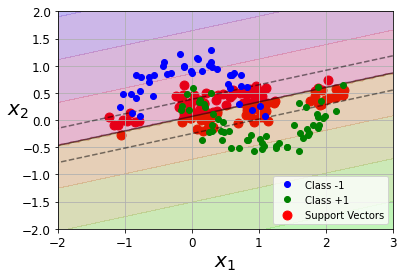

Kernel:  poly
Support vectors:  26
Hyperparameters:  {'C': 1.0, 'coef0': 1, 'degree': 4} 

Confusion Matrix: 
[[43  0]
 [ 2 55]] 

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.96      1.00      0.98        43
         1.0       1.00      0.96      0.98        57

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

Visualization: 


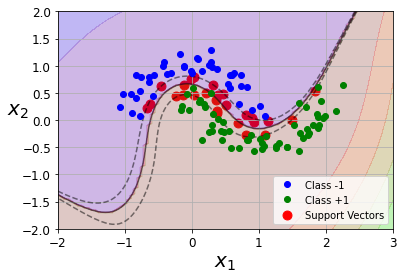

Kernel:  rbf
Support vectors:  12
Hyperparameters:  {'C': 100.0, 'gamma': 1.0} 

Confusion Matrix: 
[[43  0]
 [ 1 56]] 

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        43
         1.0       1.00      0.98      0.99        57

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Visualization: 


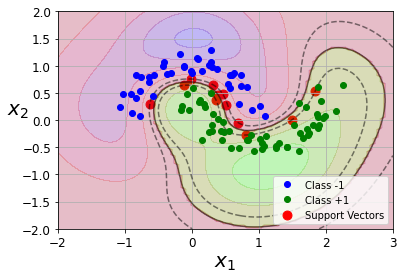

In [9]:
kernels = ['linear', 'poly', 'rbf']
svm_models = get_models_from_grid_search(grid_search.cv_results_, kernels)

evaluate_models(svm_models, kernels)

Our soft-margin **linear SVC struggles** (understandably) **to separate the data**, admitting noticeable amounts of violations on both sides of the margin. By contrast, our polynomial and RBF classifiers perform excellently, with just 2 and 1 misclassifications respectively (hence, 98% and 99% accuracies). 

We can see how **non-linear kernels allow us to model much more complex relationships** within our data.

## 3. Implementation: Custom SVCs

Now that we've seen how the standard library SVCs perform on the dataset, we attempt to implement our own version from scratch. Adopting template code from [Mathieu Blondel's article](http://web.archive.org/web/20160617002127/http://mblondel.org/journal/2010/09/19/support-vector-machines-in-python/), we work on 6 subtasks, identified in comments below.


The first step is to implement three kernel functions—which we use to transform data into non-linear feature spaces—taking care to implement the appropriate hyperparameters.

In [10]:
# Linear Kernel             
def linear_kernel(u, v):
    return np.dot(u, v)

# SUBTASK 1: Polynomial Kernel (of degree up to and including p)
def polynomial_kernel(u, v, p=3, r=1):
    return (np.dot(u, v)+r)**p 

# SUBTASK 2: Gaussian RBF Kernel
def rbf_kernel(u, v, gamma=0.1):
    return np.exp(-gamma * np.linalg.norm(u-v)**2)

In [11]:
import cvxopt # The optimization package for Quadratic Programming
import cvxopt.solvers
from sklearn.base import BaseEstimator, ClassifierMixin # Sklearn compatability

class MySVM(BaseEstimator, ClassifierMixin):
    """The Implementation of the SVM class"""

    # Note that a C of none is not recommended
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C if C is None else float(C)

    def fit(self, X, y=None):
        """
        Train SVM based on the training set
        Parameters
        ----------
        X: feature matrix shape(m_samples, n_features)
        y: label vector shape(m_samples, )
        """
        
        m_samples, n_features = X.shape

        # To speed up repeated applications of the kernel function, dynamic programming is used
        # All pairs of points have the kernel function computed over them and the result stored in K
        # K is indexed by indices in X, so K[i,j] = kernel_function(X[i], X[j])
        K = np.zeros((m_samples, m_samples))
        for i in range(m_samples):
            for j in range(m_samples):
                K[i,j] = self.kernel(X[i], X[j])
        self.K = K

        # This part requires some understanding of Quadratic Programming (QP)
        # Below is the user's guide for the QP from CVXOPT 
        # http://cvxopt.org/userguide/coneprog.html#quadratic-programming
        # DO NOT edit any of this code until Subtask 3
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(m_samples) * -1)
        A = cvxopt.matrix(y, (1,m_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(m_samples) * -1))
            h = cvxopt.matrix(np.zeros(m_samples))
        else:
            tmp1 = np.diag(np.ones(m_samples) * -1)
            tmp2 = np.identity(m_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(m_samples)
            tmp2 = np.ones(m_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b, options={'show_progress': False});

        # Lagrange multipliers for each point in X
        a = np.ravel(solution['x'])

        # SUBTASK 3: Find support vectors (non-zero lagrange multipliers)
        sv = a > 1e-3
        X_sv = X[sv]
        self.support_vectors_ = X_sv
        self.y_sv = y[sv]
        self.a_sv = a[sv]

        if self.kernel == linear_kernel:
            # SUBTASK 4: Compute weight vector w
            self.w = np.sum((self.a_sv * self.y_sv)[:, np.newaxis] * X_sv, axis=0)
        else:
            # No need to compute for w in non-linear case, as we will use the kernel trick
            self.w =  None
        
        # SUBTASK 5: Compute intercept b
        k = np.where(sv)[0][0] # unpack tuple before access
        self.b = y[k] - np.sum(self.a_sv * self.y_sv * K[k][sv]) 

    def decision_function(self, X):
        """The decision function is essentially w^T . x + b"""
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            # SUBTASK 6: Implement kernel trick for non-linear label prediction

            # Iterative approach:

            # y_predict = np.zeros(len(X)) 
            # for i in range(len(X)):
            #   for a, y, x in zip(self.a_sv, self.y_sv, self.support_vectors_):
            #       y_predict[i] += a * y * self.kernel(x, X[i])
            # return y_predict + self.b

            # Vectorized approach:

            # Combine each test example with support vector / related data values
            examples_sv_data = np.array([(x_test, self.a_sv, self.y_sv, self.support_vectors_) for x_test in X])
            # For every example, perform kernel trick on it and each support vector, then multiply each a and y value
            products = np.array([ row[1][i] * row[2][i] * self.kernel(row[3][i], row[0]) for row in examples_sv_data for i in range(len(self.support_vectors_)) ])
            # Sum all the products generated for each example
            sums = np.add.reduceat(products, np.arange(0, len(products), len(self.support_vectors_)))
            # Add bias to prediction and return!
            return sums + self.b

    def predict(self, X):
        """Predicts -1,+1 based on the sign of the decision function"""
        return np.sign(self.decision_function(X))

---
## Results & Comparison

Now that we've implemented our own SVC class with some kernel functions to go with it, we are ready to use it! 

As before, we fit the models to the train data and evaluate them on the test data; but this time, we can use the findings of our grid search earlier to preset our hyperparameters — no tuning process required!

To recap, the best hyperparameters found for the standard library SVMs were:

- **Linear:** C=10000
- **Polynomial:** C=1, r=1, degree=4
- **RBF:** C=100, gamma=1

Below we instantiate custom SVMs with the same configuration.


In [12]:
from functools import partial

mysvm_linear = MySVM(kernel=linear_kernel, C=10000)
mysvm_poly = MySVM(kernel=partial(polynomial_kernel, p=4, r=1), C=1)
mysvm_rbf = MySVM(kernel=partial(rbf_kernel, gamma=1), C=100)

mysvm_models = {'linear': mysvm_linear, 'poly': mysvm_poly, 'rbf': mysvm_rbf}

And assess their performance using the same metrics and visualization as earlier.

Kernel:  linear
Support vectors:  130
Hyperparameters:  {'C': 10000.0} 

Confusion Matrix: 
[[42  1]
 [13 44]] 

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.76      0.98      0.86        43
         1.0       0.98      0.77      0.86        57

    accuracy                           0.86       100
   macro avg       0.87      0.87      0.86       100
weighted avg       0.89      0.86      0.86       100

Visualization: 


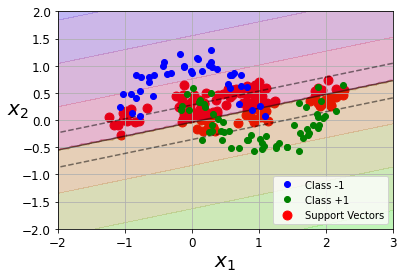

Kernel:  poly
Support vectors:  23
Hyperparameters:  {'C': 1.0} 

Confusion Matrix: 
[[43  0]
 [ 1 56]] 

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        43
         1.0       1.00      0.98      0.99        57

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Visualization: 


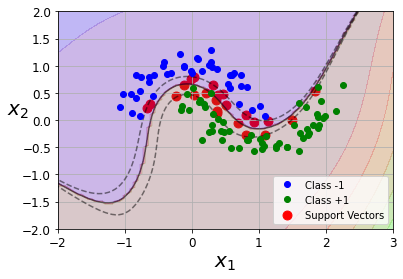

Kernel:  rbf
Support vectors:  12
Hyperparameters:  {'C': 100.0} 

Confusion Matrix: 
[[43  0]
 [ 1 56]] 

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        43
         1.0       1.00      0.98      0.99        57

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Visualization: 


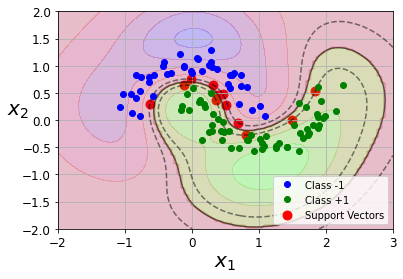

In [13]:
evaluate_models(mysvm_models, kernels)

Amazing! We see that **our hand-made classifiers achieve results comparable to standard library implementations**. Specifically,

*   **Linear**: The same number of misclassifications occur (14), hence the same accuracy. The actual margins are shifted a bit, changing which labels were misclassified. Also of note is the increased number of support vectors, from 116 to 130.

*   **Polynomial**: Very similar plots, with noticeable differences in the margin further out from the clusters. We pick up one additional correct classification in our custom implementation (98% → 99% accuracy)

*   **RBF**: We get identical margins, boundaries, and support vectors, and thus the same results as well. The two plots are carbon copies. An interesting sight!



## Conclusion

While more challenging than implementing gradient descent or the closed-form normal equation for linear regression, **building state-of-the-art kernel SVMs from the ground up is a very doable task**, and one that benefits from NumPy's vectorized operations.

Further work might explore the basis for the difference in support vectors, and how this affects weights and biases for different kernels.